# GLORYS Tracer Transport Investigation

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
from zipfile import ZipFile
import gsw
import pandas as pd
import geopandas
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import time
import datetime
from scipy.stats import linregress
from scipy.stats import t
import cmocean.cm as cmo
from erddapy import ERDDAP
import matplotlib.gridspec as gridspec
import cartopy
import geopy.distance
from scipy.interpolate import interp1d
import statsmodels.api as sm
from pyproj import Geod


## Load data

In [2]:
fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/*.nc')
glorys = xr.open_mfdataset(fnames,data_vars='minimal',coords='minimal',compat='override',chunks='auto')

## Convert to TEOS-10
pressure = gsw.p_from_z(-glorys.depth,glorys.latitude)
glorys['absolute_salinity'] = gsw.SA_from_SP(glorys.so, pressure, glorys.longitude, glorys.latitude)    
glorys['conservative_temperature'] = gsw.CT_from_pt(glorys.so, glorys.thetao)
glorys['potential_density'] = gsw.sigma0(glorys.absolute_salinity, glorys.conservative_temperature)+1000
## Update attributes
glorys.absolute_salinity.attrs['long_name'] = 'Absolute Salinity'
glorys.absolute_salinity.attrs['unit_long'] = 'Absolute Salinity'
glorys.absolute_salinity.attrs['units'] = 'g kg$^{-1}$'
glorys.conservative_temperature.attrs['long_name'] = 'Conservative Temperature'
glorys.conservative_temperature.attrs['unit_long'] = 'Conservative Temperature'
glorys.conservative_temperature.attrs['units'] = '°C'
glorys.potential_density.attrs['long_name'] = 'Potential Density'
glorys.potential_density.attrs['unit_long'] = 'Potential Density'
glorys.potential_density.attrs['units'] = 'kg m$^{-3}$'

## convert CT and AS to PT and PSU
glorys['potential_temp'] = gsw.pt_from_CT(glorys.absolute_salinity, glorys.conservative_temperature)
glorys['practical_salinity'] = gsw.SP_from_SA(glorys.absolute_salinity, gsw.p_from_z(-glorys.depth,glorys.latitude),glorys.longitude,glorys.latitude)
glorys

<xarray.Dataset>
Dimensions:                   (depth: 50, latitude: 265, longitude: 1009,
                               time: 373)
Coordinates:
  * depth                     (depth) float32 0.494 1.541 ... 5.728e+03
  * latitude                  (latitude) float32 8.0 8.083 8.167 ... 29.92 30.0
  * longitude                 (longitude) float32 -98.0 -97.92 ... -14.08 -14.0
  * time                      (time) datetime64[ns] 1993-01-01 ... 2023-12-01
Data variables:
    so                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    thetao                    (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    uo                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    vo                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    absolute_salinity         (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    conservative_temperature  (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    potential_density         (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    potential_temp            (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    practical_salinity        (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
Attributes: (12/14)
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    dataset:                       global-reanalysis-001-030-monthly
    institution:                   Mercator Ocean
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLORYS12V1
    title:                         Monthly mean fields for product GLOBAL_REA...

## Create western and eastern caribbean subsets

In [3]:
## Load western Caribbean shapefile for more precise clipping
fname ='/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/northwest_carib/northwest.shp'
nwcarib = geopandas.read_file(fname)
## Load southeastern Caribbean shapefile for more precise clipping
fname ='/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/eastern_carib/eastern.shp'
ecarib = geopandas.read_file(fname)


## Need to do this to play nice with geopandas/rio
ds = glorys.rename({'longitude': 'x','latitude': 'y'})
## Clip to Atlantic shapefile
ds = ds.rio.write_crs('WGS84', inplace=True)

west_carib_ds = ds.rio.clip(nwcarib.geometry.values, nwcarib.crs)
east_carib_ds = ds.rio.clip(ecarib.geometry.values, ecarib.crs)

west_carib_ds_mean = west_carib_ds.mean(dim=['x','y','time'])
east_carib_ds_mean = east_carib_ds.mean(dim=['x','y','time'])
west_carib_ds_std = west_carib_ds.mean(dim=['x','y']).std(dim='time')
east_carib_ds_std = east_carib_ds.mean(dim=['x','y']).std(dim='time')

## Put on dz=1m depth grid for transport calculations

In [5]:
dz = 1
grid_depth = np.arange(0.5, np.nanmax(west_carib_ds.depth.values), dz)

# west_carib_ds = west_carib_ds.chunk({'time': -1,'x':-1,'y':-1,'depth':-1})
# east_carib_ds = east_carib_ds.chunk({'time': -1,'x':-1,'y':-1,'depth':-1})

west_carib_ds_mean = west_carib_ds_mean.chunk({'depth':-1})
east_carib_ds_mean = east_carib_ds_mean.chunk({'depth':-1})

# Define a function that applies np.gradient along the depth dimension
def interp_along_depth(depth, var, grid_depth):
    interp_func = interp1d(depth, var, kind='linear',fill_value=np.nan,bounds_error=False)
    return interp_func(grid_depth)




# Use xarray's apply_ufunc to interpolate along the depth dimension
west_carib_ds_interp = xr.apply_ufunc(
    interp_along_depth,          # function to apply
    west_carib_ds_mean['depth'],            # depth array
    west_carib_ds_mean,        # cross_vel array
    grid_depth,                  # additional argument: new depth levels
    input_core_dims=[['depth'], ['depth'], ['grid_depth']],  # specify input dimensions
    output_core_dims=[['grid_depth']],           # specify output dimension
    vectorize=True,              # vectorize the function
    dask='parallelized',         # enable parallel computation with dask
    output_dtypes=[ds.uo.dtype]     # output dtype
)

# Use xarray's apply_ufunc to interpolate along the depth dimension
east_carib_ds_interp = xr.apply_ufunc(
    interp_along_depth,          # function to apply
    east_carib_ds_mean['depth'],            # depth array
    east_carib_ds_mean,        # cross_vel array
    grid_depth,                  # additional argument: new depth levels
    input_core_dims=[['depth'], ['depth'], ['grid_depth']],  # specify input dimensions
    output_core_dims=[['grid_depth']],           # specify output dimension
    vectorize=True,              # vectorize the function
    dask='parallelized',         # enable parallel computation with dask
    output_dtypes=[ds.uo.dtype]     # output dtype
)


# # Use xarray's apply_ufunc to interpolate along the depth dimension
# west_carib_ds_interp = xr.apply_ufunc(
#     interp_along_depth,          # function to apply
#     west_carib_ds['depth'],            # depth array
#     west_carib_ds,        # cross_vel array
#     grid_depth,                  # additional argument: new depth levels
#     input_core_dims=[['depth'], ['time', 'y', 'x', 'depth'], ['grid_depth']],  # specify input dimensions
#     output_core_dims=[['time', 'y', 'x', 'grid_depth']],           # specify output dimension
#     vectorize=True,              # vectorize the function
#     dask='parallelized',         # enable parallel computation with dask
#     output_dtypes=[ds.uo.dtype]     # output dtype
# )

# # Use xarray's apply_ufunc to interpolate along the depth dimension
# east_carib_ds_interp = xr.apply_ufunc(
#     interp_along_depth,          # function to apply
#     east_carib_ds['depth'],            # depth array
#     east_carib_ds,        # cross_vel array
#     grid_depth,                  # additional argument: new depth levels
#     input_core_dims=[['depth'], ['time', 'y', 'x', 'depth'], ['grid_depth']],  # specify input dimensions
#     output_core_dims=[['time', 'y', 'x', 'grid_depth']],           # specify output dimension
#     vectorize=True,              # vectorize the function
#     dask='parallelized',         # enable parallel computation with dask
#     output_dtypes=[ds.uo.dtype]     # output dtype
# )

west_carib_ds_interp = west_carib_ds_interp.rename({'grid_depth': 'depth'})
east_carib_ds_interp = east_carib_ds_interp.rename({'grid_depth': 'depth'})
west_carib_ds_interp

<xarray.Dataset>
Dimensions:                   (depth: 5728)
Coordinates:
    spatial_ref               int64 0
Dimensions without coordinates: depth
Data variables:
    so                        (depth) float32 dask.array<chunksize=(5728,), meta=np.ndarray>
    thetao                    (depth) float32 dask.array<chunksize=(5728,), meta=np.ndarray>
    uo                        (depth) float32 dask.array<chunksize=(5728,), meta=np.ndarray>
    vo                        (depth) float32 dask.array<chunksize=(5728,), meta=np.ndarray>
    absolute_salinity         (depth) float32 dask.array<chunksize=(5728,), meta=np.ndarray>
    conservative_temperature  (depth) float32 dask.array<chunksize=(5728,), meta=np.ndarray>
    potential_density         (depth) float32 dask.array<chunksize=(5728,), meta=np.ndarray>
    potential_temp            (depth) float32 dask.array<chunksize=(5728,), meta=np.ndarray>
    practical_salinity        (depth) float32 dask.array<chunksize=(5728,), meta=np.ndarray>

## Mean and std profiles for test scenario at end of workflow

In [7]:
# west_carib_ds_mean = west_carib_ds_interp.mean(dim=['x','y','time'])
# east_carib_ds_mean = east_carib_ds_interp.mean(dim=['x','y','time'])
# west_carib_ds_std = west_carib_ds_interp.mean(dim=['x','y']).std(dim='time')
# east_carib_ds_std = east_carib_ds_interp.mean(dim=['x','y']).std(dim='time')

## Load them into memory to ensure it doesn't blow up later?

In [8]:
west_carib_ds_interp['potential_temp'] = west_carib_ds_interp.potential_temp.load()
west_carib_ds_interp['absolute_salinity'] = west_carib_ds_interp.absolute_salinity.load()
west_carib_ds_interp['practical_salinity'] = west_carib_ds_interp.practical_salinity.load()

east_carib_ds_interp['potential_temp'] = east_carib_ds_interp.potential_temp.load()
east_carib_ds_interp['absolute_salinity'] = east_carib_ds_interp.absolute_salinity.load()
east_carib_ds_interp['practical_salinity'] = east_carib_ds_interp.practical_salinity.load()


## Greater Atlantic slice

In [9]:
glorys_atl = glorys.where((glorys.latitude==21.5) & (glorys.longitude>=-77.5),drop=True)
glorys_atl

<xarray.Dataset>
Dimensions:                   (time: 373, depth: 50, latitude: 1, longitude: 763)
Coordinates:
  * depth                     (depth) float32 0.494 1.541 ... 5.728e+03
  * latitude                  (latitude) float32 21.5
  * longitude                 (longitude) float32 -77.5 -77.42 ... -14.08 -14.0
  * time                      (time) datetime64[ns] 1993-01-01 ... 2023-12-01
Data variables:
    so                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
    thetao                    (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
    uo                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
    vo                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
    absolute_salinity         (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
    conservative_temperature  (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
    potential_density         (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
    potential_temp            (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
    practical_salinity        (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
Attributes: (12/14)
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    dataset:                       global-reanalysis-001-030-monthly
    institution:                   Mercator Ocean
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLORYS12V1
    title:                         Monthly mean fields for product GLOBAL_REA...

## Calculate horizontal grid spacing in meters

In [10]:
dx = geopy.distance.geodesic([glorys_atl.longitude.values[0],glorys_atl.latitude.values[0]], [glorys_atl.longitude.values[1],glorys_atl.latitude.values[0]]).m
dx

9303.680337611735

## Put on dz=1m depth grid for transport calculations

In [11]:
dz = 1
grid_depth = np.arange(0.5, glorys_atl.depth.max().values, dz)

def depth_interp(old_depth,vel,new_depth):
    # new_vel = np.empty((len(new_depth),len(glorys_atl.longitude)))
    # new_vel[:] = np.nan

    interp_func = interp1d(old_depth, vel, kind='linear')
    return interp_func(new_depth)

    # for x in np.arange(0,len(glorys_atl.longitude)):
    #     interp_func = interp1d(old_depth, vel[:,x], kind='linear')
    #     new_vel[:,x] = interp_func(new_depth)
    # return new_vel

glorys_atl = glorys_atl.chunk({'depth': -1})
glorys_atl = glorys_atl.chunk({'longitude': -1})

# Apply the function using xarray's apply_ufunc
glorys_atl_interp = xr.apply_ufunc(
    depth_interp,                            # function to apply
    glorys_atl.depth,                           # additional argument to pass to the function
    glorys_atl.isel(latitude=0),                        # additional argument to pass to the function
    grid_depth,                              # input array
    input_core_dims=[['depth'], ['depth'],['new_depth']],  # core dimensions for input arrays
    output_core_dims=[['new_depth']],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[glorys_atl.vo.dtype]      # output dtype
)


In [12]:
glorys_atl_interp = glorys_atl_interp.rename({'new_depth':'depth'})
glorys_atl_interp

<xarray.Dataset>
Dimensions:                   (time: 373, longitude: 763, depth: 5728)
Coordinates:
    latitude                  float32 21.5
  * longitude                 (longitude) float32 -77.5 -77.42 ... -14.08 -14.0
  * time                      (time) datetime64[ns] 1993-01-01 ... 2023-12-01
Dimensions without coordinates: depth
Data variables:
    so                        (time, longitude, depth) float32 dask.array<chunksize=(8, 763, 5728), meta=np.ndarray>
    thetao                    (time, longitude, depth) float32 dask.array<chunksize=(8, 763, 5728), meta=np.ndarray>
    uo                        (time, longitude, depth) float32 dask.array<chunksize=(8, 763, 5728), meta=np.ndarray>
    vo                        (time, longitude, depth) float32 dask.array<chunksize=(8, 763, 5728), meta=np.ndarray>
    absolute_salinity         (time, longitude, depth) float32 dask.array<chunksize=(8, 763, 5728), meta=np.ndarray>
    conservative_temperature  (time, longitude, depth) float32 dask.array<chunksize=(8, 763, 5728), meta=np.ndarray>
    potential_density         (time, longitude, depth) float32 dask.array<chunksize=(8, 763, 5728), meta=np.ndarray>
    potential_temp            (time, longitude, depth) float32 dask.array<chunksize=(8, 763, 5728), meta=np.ndarray>
    practical_salinity        (time, longitude, depth) float32 dask.array<chunksize=(8, 763, 5728), meta=np.ndarray>

## Transport per unit depth

In [13]:
atl_transport_per_unit_depth = (glorys_atl_interp.vo*dx)
#atl_transport_per_unit_depth.sum(dim=['depth','longitude']).mean(dim='time').values/(10**6)

## Yucatan Straits transport

In [14]:
geodesic = Geod(ellps="WGS84")  # define the coordinate system. WGS84 is the standard used by GPS.

def calculate_transect(start, end, dist=5000):
    from pyproj import Geod
    g = Geod(ellps="WGS84")
    
    pts = g.inv_intermediate(start[0], start[1], end[0], end[1], 0, dist) 
    _, _, dist = g.inv(np.full(len(pts.lons), start[0]), np.full(len(pts.lons), start[1]), pts.lons, pts.lats)
    return np.column_stack([pts.lons, pts.lats]), dist


def reckon(origin_lon, origin_lat, forward_azimuth, distance):
    """
    Calculate lon, lat of a point from a specified azimuth, distance on sphere or ellipsoid
    Helper function for pyproj.Geod forward transformation

    Args:
        origin_lon (array, numpy.ndarray, list, tuple, or scalar):
            Longitude(s) of initial point(s)
        origin_lat (array, numpy.ndarray, list, tuple, or scalar):
            Latitude(s) of initial point(s)
        forward_azimuth (array, numpy.ndarray, list, tuple, or scalar):
            Azimuth/bearing(s) of the terminus point relative to the initial point(s)
        distance (array, numpy.ndarray, list, tuple, or scalar):
            Distance(s) between initial and terminus point(s) in kilometers

    Returns:
        array, numpy.ndarray, list, tuple, or scalar: Longitude(s) of terminus point(s)
        array, numpy.ndarray, list, tuple, or scalar: Latitude(s) of terminus point(s)
        array, numpy.ndarray, list, tuple, or scalar: Backwards azimuth(s) of terminus point(s)
    """
    terminus_lon, terminus_lat, _ = geodesic.fwd(origin_lon, origin_lat, forward_azimuth, distance * 1000)
    return terminus_lon, terminus_lat



yucatan_pt1 = [-86.742, 21.1256]
yucatan_pt2 = [-84.9348, 21.837]

yucatan_dx = 9000

pts, dist = calculate_transect(yucatan_pt1, yucatan_pt2, yucatan_dx) # 9km spacing to ~match the 1/12 deg GLORYS resolution



glorys_rn = glorys.rename({'longitude': 'x','latitude': 'y'})


# Interpolate Copernicus Transect
yucatan = glorys_rn.interp(
    x=xr.DataArray(pts[:,0], dims="point"),
    y=xr.DataArray(pts[:,1], dims="point"),
)

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/pyproj/geod.py:681: UserWarning: Back azimuth is being returned by default to be compatible with fwd()This is a breaking change for pyproj 3.5+.To avoid this warning, set return_back_azimuth=True.Otherwise, to restore old behaviour, set return_back_azimuth=False.This warning will be removed in future version.
  warnings.warn(


## Put on dz=1m depth grid for transport calculations

In [15]:
dz = 1
grid_depth = np.arange(0.5, np.nanmax(yucatan.depth.values), dz)


yucatan = yucatan.chunk({'time': -1,'depth':-1})


# Define a function that applies np.gradient along the depth dimension
def interp_along_depth(depth, var, grid_depth):
    interp_func = interp1d(depth, var, kind='linear',fill_value=np.nan,bounds_error=False)
    return interp_func(grid_depth)


# Use xarray's apply_ufunc to interpolate along the depth dimension
yucatan_interp = xr.apply_ufunc(
    interp_along_depth,          # function to apply
    yucatan['depth'],            # depth array
    yucatan,        # cross_vel array
    grid_depth,                  # additional argument: new depth levels
    input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
    output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
    vectorize=True,              # vectorize the function
    dask='parallelized',         # enable parallel computation with dask
    output_dtypes=[yucatan.uo.dtype]     # output dtype
)

yucatan_interp = yucatan_interp.rename({'grid_depth': 'depth'})

## Make sure only getting velocity profiles where there's not-nans

In [16]:
yucatan_finite_depths = np.sum((np.isfinite(yucatan_interp.vo.isel(time=0)).values==True),axis=1)
yucatan_area = np.sum(yucatan_finite_depths*yucatan_dx)
yucatan_area

212481000

## Calculate Yucatan Transport

In [17]:
yucatan_transport_per_unit_depth = yucatan_interp.vo*yucatan_dx
#yucatan_transport_per_unit_depth.sum(dim=['point','depth']).mean(dim='time').values/(10**6)

## Potential Adjustment

In [18]:
## Find the maximum depth of finite velocity data in the yucatan straits
yucatan_vel_max_depth = 1942 # from other GLORYS work
## Difference in the transport values between the yucatan straits and greater atlantic
trsp_diff = -(yucatan_transport_per_unit_depth.sum(dim=['point','depth']).mean(dim='time').values)-(atl_transport_per_unit_depth.sum(dim=['depth','longitude']).mean(dim='time').values)
## divide that transport diff by the depth of the profile to find the adjustment per unit depth
adjustment_per_unit_depth = trsp_diff/yucatan_area ## m
adjustment_per_unit_depth

0.006089664487648307

## Adjust

In [19]:
for x in np.arange(0,len(yucatan_finite_depths)):
    yucatan_interp.vo[:,x,0:yucatan_finite_depths[x]] = yucatan_interp.vo[:,x,0:yucatan_finite_depths[x]]+adjustment_per_unit_depth

yucatan_transport_per_unit_depth = yucatan_interp.vo*yucatan_dx


## Confirm volume flux is balanced now

In [20]:
yucatan_transport_per_unit_depth.sum(dim=['point','depth']).mean(dim='time').values/(10**6)

29.196854

In [21]:
atl_transport_per_unit_depth.sum(dim=['depth','longitude']).mean(dim='time').values/(10**6)

-29.196854

## Save and reload for faster computations

In [22]:
# glorys_atl_interp = glorys_atl_interp.drop_vars(["vo", "uo", "so", "thetao","potential_density","conservative_temperature"])
# glorys_atl_interp['transport_per_unit_depth'] = atl_transport_per_unit_depth
# yucatan_interp['transport_per_unit_depth'] = yucatan_transport_per_unit_depth
# yucatan_interp.load().to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_Yucatan_Straits_Interp_1993_2023.nc')

In [23]:
yucatan_interp = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_Yucatan_Straits_Interp_1993_2023.nc')
yucatan_interp

<xarray.Dataset>
Dimensions:                   (time: 373, point: 22, depth: 5728)
Coordinates:
  * time                      (time) datetime64[ns] 1993-01-01 ... 2023-12-01
    x                         (point) float64 ...
    y                         (point) float64 ...
Dimensions without coordinates: point, depth
Data variables:
    so                        (time, point, depth) float32 ...
    thetao                    (time, point, depth) float32 ...
    uo                        (time, point, depth) float32 ...
    vo                        (time, point, depth) float32 ...
    absolute_salinity         (time, point, depth) float32 ...
    conservative_temperature  (time, point, depth) float32 ...
    potential_density         (time, point, depth) float32 ...
    potential_temp            (time, point, depth) float32 ...
    practical_salinity        (time, point, depth) float32 ...
    transport_per_unit_depth  (time, point, depth) float32 ...

# Tracer transports

## Heat Transport

In [24]:
rho_Cp =  4.1 * (10**6) ## From Johns et al. (2011) [J/(kg*C)]
heat_transport_yucatan = yucatan_interp.potential_temp*yucatan_interp.transport_per_unit_depth*rho_Cp

In [48]:
#heat_transport_atl = glorys_atl_interp.potential_temp*glorys_atl_interp.transport_per_unit_depth*rho_Cp
#heat_transport_atl.load().to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_ATL_Heat_Transport_Interp_1993_2023.nc')
heat_transport_atl = xr.load_dataarray('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_ATL_Heat_Transport_Interp_1993_2023.nc')

In [49]:
net_heat_transport = heat_transport_yucatan.sum(dim=['depth','point'])+heat_transport_atl.sum(dim=['depth','longitude'])
#net_heat_transport = net_heat_transport.rename({'__xarray_dataarray_variable__':'heat_transport'}).load()

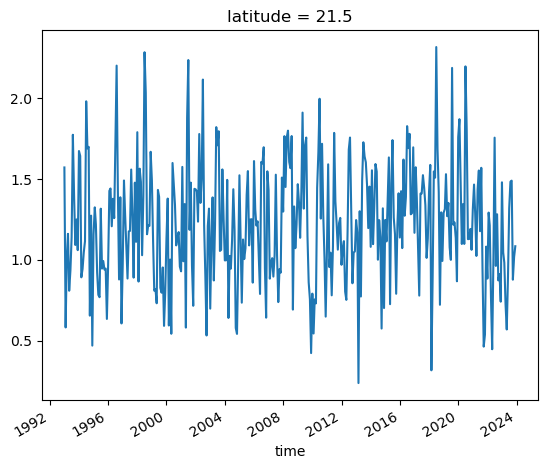

In [51]:
(net_heat_transport/(10**15)).plot()

In [52]:
net_heat_transport.mean().values/(10**15)

1.219022045577216

## Salt Transport

In [53]:
psu_transport_yucatan = yucatan_interp.practical_salinity*yucatan_interp.transport_per_unit_depth
salt_transport_yucatan = yucatan_interp.absolute_salinity*yucatan_interp.transport_per_unit_depth

In [54]:
#psu_transport_atl = glorys_atl_interp.practical_salinity*glorys_atl_interp.transport_per_unit_depth
#salt_transport_atl = glorys_atl_interp.absolute_salinity*glorys_atl_interp.transport_per_unit_depth
#psu_transport_atl.load().to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_ATL_PSU_Transport_Interp_1993_2023.nc')
#salt_transport_atl.load().to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_ATL_SALT_Transport_Interp_1993_2023.nc')

psu_transport_atl = xr.load_dataarray('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_ATL_PSU_Transport_Interp_1993_2023.nc')
salt_transport_atl = xr.load_dataarray('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_ATL_SALT_Transport_Interp_1993_2023.nc')

In [57]:
net_psu_transport = psu_transport_yucatan.sum(dim=['depth','point'])+psu_transport_atl.sum(dim=['depth','longitude'])
net_salt_transport = salt_transport_yucatan.sum(dim=['depth','point'])+salt_transport_atl.sum(dim=['depth','longitude'])

# net_psu_transport = net_psu_transport.rename({'__xarray_dataarray_variable__':'net_psu_transport'}).load()
# net_salt_transport = net_salt_transport.rename({'__xarray_dataarray_variable__':'net_salt_transport'}).load()

In [58]:
net_psu_transport.mean().values/(10**6)

8.71306

## Freshwater Transport


In [59]:
#sbar = glorys_atl_interp.practical_salinity.mean().values
sbar = 35.16371 ## This value is from the above line of code but it is essentially a constant so don't need to reload that massive dataset every time this notebook is run

In [62]:
#atl_freshwater_transport = (-1/sbar)*((glorys_atl_interp.practical_salinity*glorys_atl_interp.transport_per_unit_depth)-(glorys_atl_interp.transport_per_unit_depth*sbar))
#atl_freshwater_transport.load().to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_ATL_FW_Transport_Interp_1993_2023.nc')
atl_freshwater_transport = xr.load_dataarray('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_ATL_FW_Transport_Interp_1993_2023.nc')
#atl_freshwater_transport = atl_freshwater_transport.rename({'__xarray_dataarray_variable__':'atl_freshwater_transport'}).load()

In [63]:
yucatan_freshwater_transport = (-1/sbar)*((yucatan_interp.practical_salinity*yucatan_interp.transport_per_unit_depth)-(yucatan_interp.transport_per_unit_depth*sbar))
net_freshwater_transport = atl_freshwater_transport.sum(dim=['depth','longitude']).values+yucatan_freshwater_transport.sum(dim=['depth','point'])

In [64]:
net_freshwater_transport.mean().values/(10**6)

-0.24778475

## Now do heat, salt, and freshwater transport with MEAN WESTERN CARIBBEAN T/S profile and see how it compares to having the actual salinity field across the Yucatan Straits

## Heat Transport

In [65]:
heat_transport_yucatan_west = west_carib_ds_interp.potential_temp*yucatan_interp.transport_per_unit_depth*rho_Cp
net_heat_transport_west = heat_transport_yucatan_west.sum(dim=['depth','point'])+heat_transport_atl.sum(dim=['depth','longitude'])

In [66]:
net_heat_transport_west.mean()/(10**15)

<xarray.DataArray ()>
array(1.24996715)
Coordinates:
    spatial_ref  int64 0
    latitude     float32 21.5

## Salt Transport

In [67]:
psu_transport_yucatan_west = west_carib_ds_interp.practical_salinity*yucatan_interp.transport_per_unit_depth
salt_transport_yucatan_west = west_carib_ds_interp.absolute_salinity*yucatan_interp.transport_per_unit_depth

net_psu_transport_west = psu_transport_yucatan_west.sum(dim=['depth','point'])+psu_transport_atl.sum(dim=['depth','longitude'])
net_salt_transport_west = salt_transport_yucatan_west.sum(dim=['depth','point'])+salt_transport_atl.sum(dim=['depth','longitude'])


In [68]:
net_psu_transport_west.mean().values/(10**6)

9.048513

## Freshwater Transport

In [69]:
yucatan_freshwater_transport_west = (-1/sbar)*((west_carib_ds_interp.practical_salinity*yucatan_interp.transport_per_unit_depth)-(yucatan_interp.transport_per_unit_depth*sbar))
net_freshwater_transport_west = atl_freshwater_transport.sum(dim=['depth','longitude']).values+yucatan_freshwater_transport_west.sum(dim=['depth','point'])

In [70]:
net_freshwater_transport_west.mean().values/(10**6)

-0.2573243125

## Then do heat, salt, and freshwater transport with MEAN EASTERN CARIBBEAN T/S profile and see how it compares with above two

## Heat Transport

In [71]:
heat_transport_yucatan_east = east_carib_ds_interp.potential_temp*yucatan_interp.transport_per_unit_depth*rho_Cp
net_heat_transport_east = heat_transport_yucatan_east.sum(dim=['depth','point'])+heat_transport_atl.sum(dim=['depth','longitude'])

In [72]:
net_heat_transport_east.mean()/(10**15)

<xarray.DataArray ()>
array(1.09824797)
Coordinates:
    spatial_ref  int64 0
    latitude     float32 21.5

## Salt Transport

In [73]:
psu_transport_yucatan_east = east_carib_ds_interp.practical_salinity*yucatan_interp.transport_per_unit_depth
salt_transport_yucatan_east = east_carib_ds_interp.absolute_salinity*yucatan_interp.transport_per_unit_depth

net_psu_transport_east = psu_transport_yucatan_east.sum(dim=['depth','point'])+psu_transport_atl.sum(dim=['depth','longitude'])
net_salt_transport_east = salt_transport_yucatan_east.sum(dim=['depth','point'])+salt_transport_atl.sum(dim=['depth','longitude'])


In [74]:
net_psu_transport_east.mean().values/(10**6)

2.8013

## Freshwater Transport

In [75]:
yucatan_freshwater_transport_east = (-1/sbar)*((east_carib_ds_interp.practical_salinity*yucatan_interp.transport_per_unit_depth)-(yucatan_interp.transport_per_unit_depth*sbar))
net_freshwater_transport_east = atl_freshwater_transport.sum(dim=['depth','longitude']).values+yucatan_freshwater_transport_east.sum(dim=['depth','point'])

In [76]:
net_freshwater_transport_east.mean().values/(10**6)

-0.079663453125

## Try plotting it up now

## First heat transport

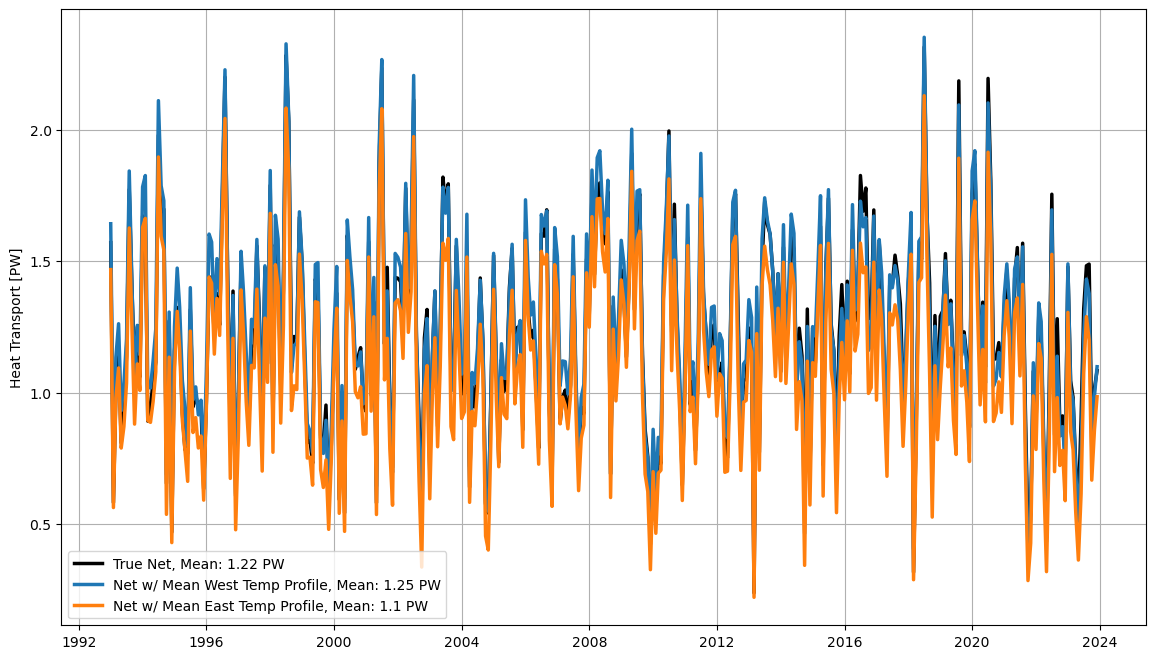

In [154]:
lwd = 2.5

plt.figure(figsize=(14,8))
plt.plot(net_heat_transport.time,net_heat_transport/(10**15),label='True Net, Mean: '+str(np.round(net_heat_transport.mean().values/(10**15),2))+' PW',color='black',linewidth=lwd)
plt.plot(net_heat_transport_west.time,net_heat_transport_west/(10**15),label='Net w/ Mean West Temp Profile, Mean: '+str(np.round(net_heat_transport_west.mean().values/(10**15),2))+' PW',color='tab:blue',linewidth=lwd)
plt.plot(net_heat_transport_east.time,net_heat_transport_east/(10**15),label='Net w/ Mean East Temp Profile, Mean: '+str(np.round(net_heat_transport_east.mean().values/(10**15),2))+' PW',color='tab:orange',linewidth=lwd)
plt.ylabel('Heat Transport [PW]')
plt.grid()
plt.legend(loc='lower left')
plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/GLORYS_Eastern_Western_Yucatan_Heat_Transport.png', bbox_inches='tight',dpi=300,facecolor='white')


(10957.0, 11688.0)

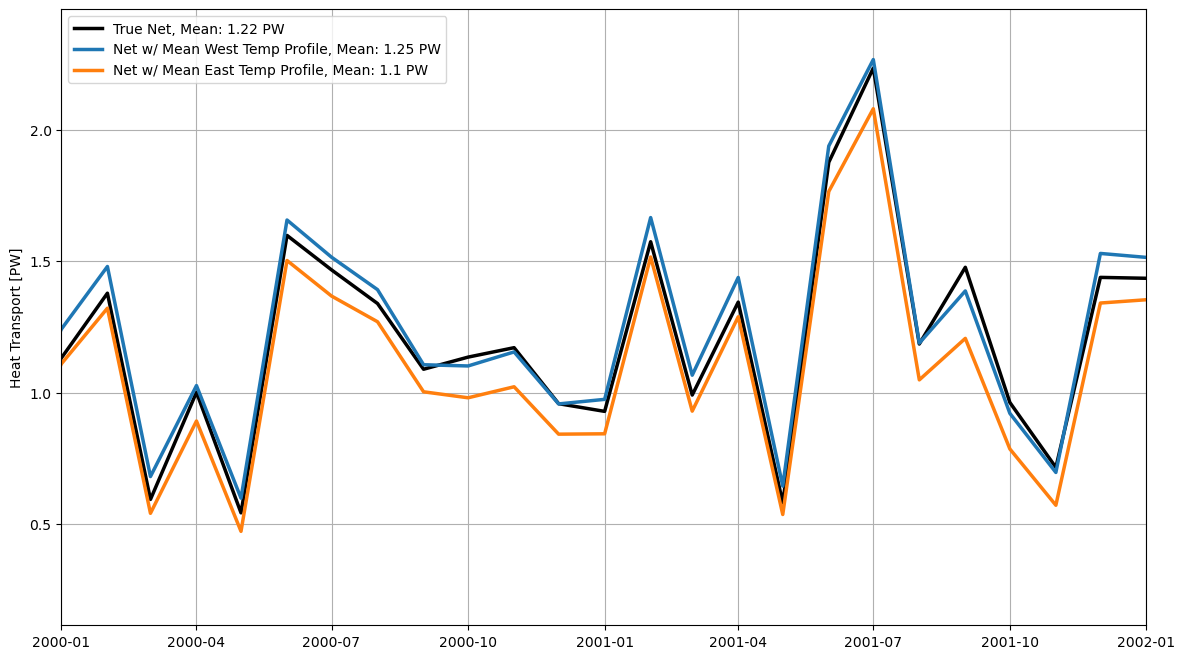

In [93]:
lwd = 2.5

plt.figure(figsize=(14,8))
plt.plot(net_heat_transport.time,net_heat_transport/(10**15),label='True Net, Mean: '+str(np.round(net_heat_transport.mean().values/(10**15),2))+' PW',color='black',linewidth=lwd)
plt.plot(net_heat_transport_west.time,net_heat_transport_west/(10**15),label='Net w/ Mean West Temp Profile, Mean: '+str(np.round(net_heat_transport_west.mean().values/(10**15),2))+' PW',color='tab:blue',linewidth=lwd)
plt.plot(net_heat_transport_east.time,net_heat_transport_east/(10**15),label='Net w/ Mean East Temp Profile, Mean: '+str(np.round(net_heat_transport_east.mean().values/(10**15),2))+' PW',color='tab:orange',linewidth=lwd)
plt.ylabel('Heat Transport [PW]')
plt.grid()
plt.legend()
plt.xlim(pd.to_datetime('2000'),pd.to_datetime('2002'))

In [124]:
percent_difference_west = abs(net_heat_transport.mean() - net_heat_transport_west.mean()) / ((net_heat_transport.mean() + net_heat_transport_west.mean()) / 2) * 100
percent_difference_east = abs(net_heat_transport.mean() - net_heat_transport_east.mean()) / ((net_heat_transport.mean() + net_heat_transport_east.mean()) / 2) * 100
percent_difference_west.values

array(2.50670222)

In [125]:
percent_difference_east.values

array(10.42382372)

## Then salt transport

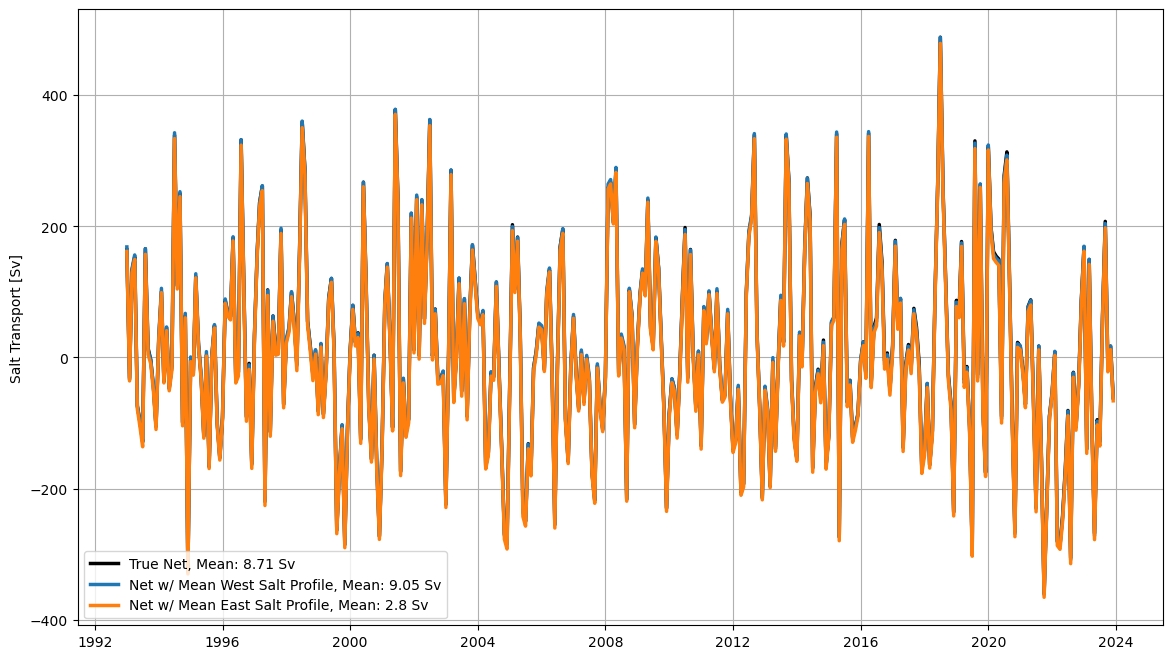

In [153]:
lwd = 2.5

plt.figure(figsize=(14,8))
plt.plot(net_psu_transport.time,net_psu_transport/(10**6),label='True Net, Mean: '+str(np.round(net_psu_transport.mean().values/(10**6),2))+' Sv',color='black',linewidth=lwd)
plt.plot(net_psu_transport_west.time,net_psu_transport_west/(10**6),label='Net w/ Mean West Salt Profile, Mean: '+str(np.round(net_psu_transport_west.mean().values/(10**6),2))+' Sv',color='tab:blue',linewidth=lwd)
plt.plot(net_psu_transport_east.time,net_psu_transport_east/(10**6),label='Net w/ Mean East Salt Profile, Mean: '+str(np.round(net_psu_transport_east.mean().values/(10**6),2))+' Sv',color='tab:orange',linewidth=lwd)
plt.ylabel('Salt Transport [Sv]')
plt.grid()
plt.legend(loc='lower left')
plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/GLORYS_Eastern_Western_Yucatan_PSU_Transport.png', bbox_inches='tight',dpi=300,facecolor='white')


In [122]:
percent_difference_west = abs(net_psu_transport.mean() - net_psu_transport_west.mean()) / ((net_psu_transport.mean() + net_psu_transport_west.mean()) / 2) * 100
percent_difference_east = abs(net_psu_transport.mean() - net_psu_transport_east.mean()) / ((net_psu_transport.mean() + net_psu_transport_east.mean()) / 2) * 100
percent_difference_west.values

array(3.77728953)

In [123]:
percent_difference_east.values

array(102.68499508)

In [128]:
net_psu_transport.mean()/net_psu_transport_east.mean()

<xarray.DataArray ()>
array(3.110363, dtype=float32)
Coordinates:
    latitude     float32 21.5
    spatial_ref  int64 0

## Freshwater transport

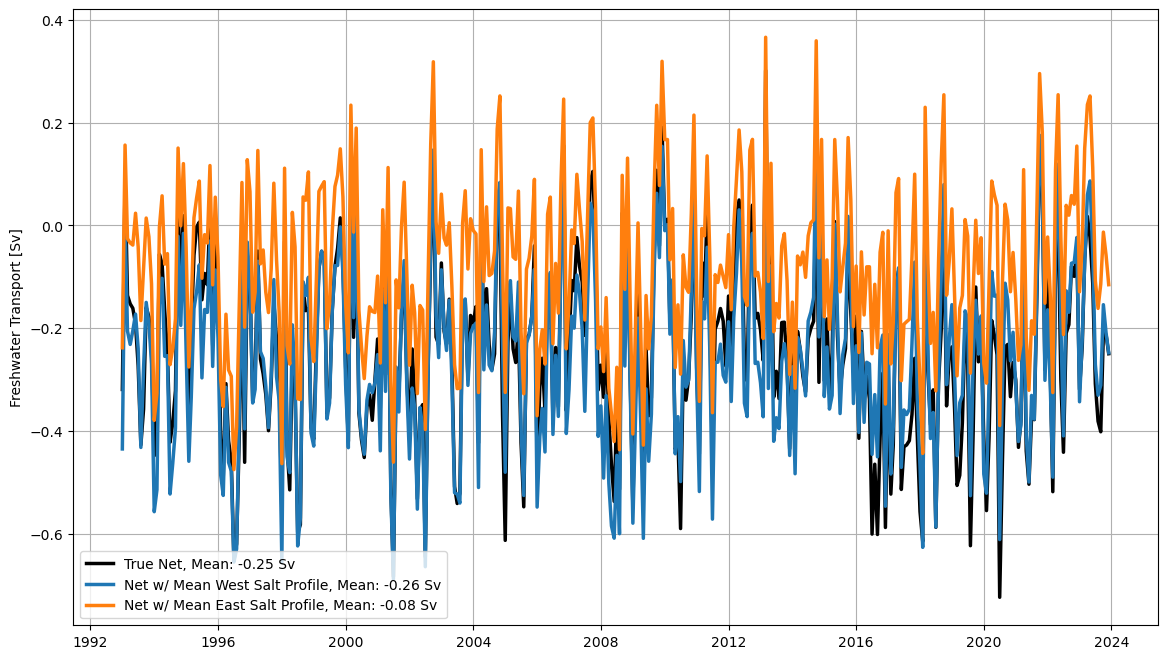

In [152]:
lwd = 2.5

plt.figure(figsize=(14,8))
plt.plot(net_freshwater_transport.time,net_freshwater_transport/(10**6),label='True Net, Mean: '+str(np.round(net_freshwater_transport.mean().values/(10**6),2))+' Sv',color='black',linewidth=lwd)
plt.plot(net_freshwater_transport_west.time,net_freshwater_transport_west/(10**6),label='Net w/ Mean West Salt Profile, Mean: '+str(np.round(net_freshwater_transport_west.mean().values/(10**6),2))+' Sv',color='tab:blue',linewidth=lwd)
plt.plot(net_freshwater_transport_east.time,net_freshwater_transport_east/(10**6),label='Net w/ Mean East Salt Profile, Mean: '+str(np.round(net_freshwater_transport_east.mean().values/(10**6),2))+' Sv',color='tab:orange',linewidth=lwd)
plt.ylabel('Freshwater Transport [Sv]')
plt.grid()
plt.legend(loc='lower left')
plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/GLORYS_Eastern_Western_Yucatan_FW_Transport.png', bbox_inches='tight',dpi=300,facecolor='white')


In [118]:
percent_difference_west = abs(abs(net_freshwater_transport.mean())-abs(net_freshwater_transport_west.mean())) / ((abs(net_freshwater_transport.mean()) + abs(net_freshwater_transport_west.mean())) / 2) * 100
percent_difference_east = abs(abs(net_freshwater_transport.mean())-abs(net_freshwater_transport_east.mean())) / ((abs(net_freshwater_transport.mean()) + abs(net_freshwater_transport_east.mean())) / 2) * 100
percent_difference_west.mean().values

array(3.7772288)

In [119]:
percent_difference_east.mean().values

array(102.68573979)

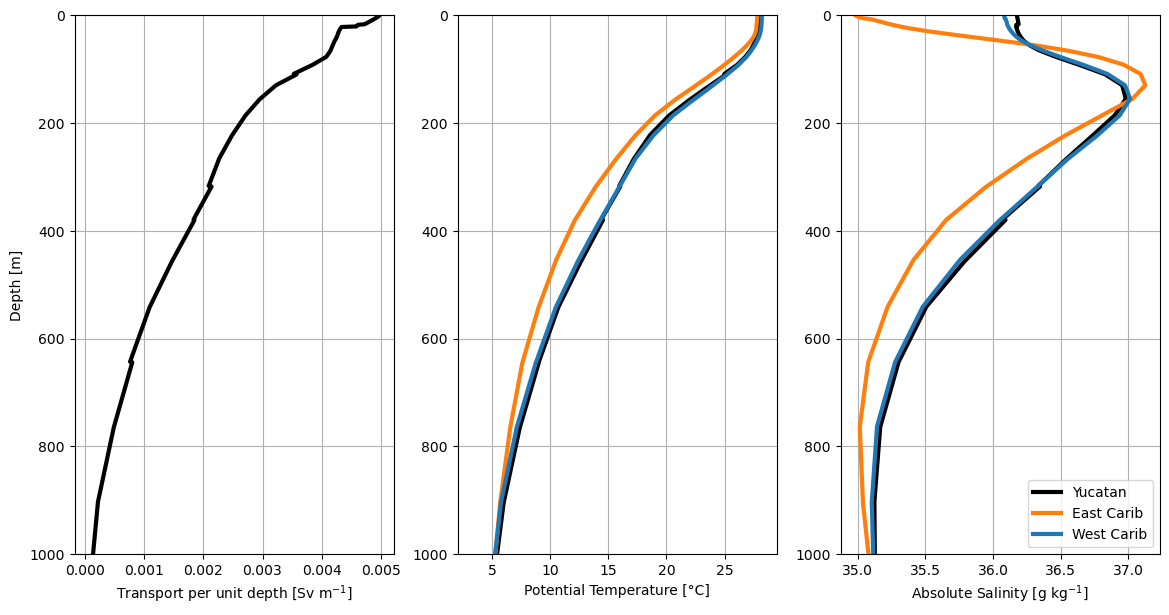

In [158]:
lwd =3

fig, ax = plt.subplots(1,3,figsize=(14,7))
ax[0].plot(yucatan_interp.transport_per_unit_depth.mean(dim=['time','point'])/(10**6),yucatan_interp.depth,color='black',linewidth=lwd)
ax[0].set_ylim(1000,0)
ax[0].set_xlabel('Transport per unit depth [Sv m$^{-1}$]')
ax[0].set_ylabel('Depth [m]')
ax[0].grid()


ax[1].plot(yucatan_interp.potential_temp.mean(dim=['time','point']),yucatan_interp.depth,color='black',linewidth=lwd)
ax[1].plot(east_carib_ds_interp.potential_temp,east_carib_ds_interp.depth,color='tab:orange',linewidth=lwd)
ax[1].plot(west_carib_ds_interp.potential_temp,west_carib_ds_interp.depth,color='tab:blue',linewidth=lwd)
ax[1].set_ylim(1000,0)
ax[1].set_xlabel('Potential Temperature [°C]')
ax[1].grid()

ax[2].plot(yucatan_interp.absolute_salinity.mean(dim=['time','point']),yucatan_interp.depth,color='black',label='Yucatan',linewidth=lwd)
ax[2].plot(east_carib_ds_interp.absolute_salinity,east_carib_ds_interp.depth,color='tab:orange',label='East Carib',linewidth=lwd)
ax[2].plot(west_carib_ds_interp.absolute_salinity,west_carib_ds_interp.depth,color='tab:blue',label='West Carib',linewidth=lwd)
ax[2].set_ylim(1000,0)
ax[2].set_xlabel('Absolute Salinity [g kg$^{-1}$]')
ax[2].grid()
ax[2].legend()

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/GLORYS/GLORYS_Eastern_Western_T_S_Profiles_w_Yucatan_Transport.png', bbox_inches='tight',dpi=300,facecolor='white')
